<a href="https://colab.research.google.com/github/shilpasy/NLP_DiscoveryHub/blob/main/NLP_Topic_Modeling_for_Research_Articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pandas as pd
import gzip
#import ujson as json

In [68]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [69]:
from google.colab import drive
drive.mount('/content/drive')
res_articles = pd.read_csv('/content/drive/My Drive/NLP/Train.csv')
Tags = pd.read_csv('/content/drive/My Drive/NLP/Tags.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


With the vast availability of scientific articles in online archives, researchers face increasing challenges in locating pertinent articles. Tagging and topic modeling offer a practical solution by providing clear identification markers for research articles, thereby streamlining the recommendation and search processes. We are going to explore this dataset for Topic modelling.

In [70]:
res_articles.head()

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,1824,a ever-growing datasets inside observational a...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3094,we propose the framework considering optimal $...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8463,nanostructures with open shell transition meta...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2082,stars are self-gravitating fluids inside which...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8687,deep neural perception and control networks ar...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
res_articles.columns

Index(['id', 'ABSTRACT', 'Computer Science', 'Mathematics', 'Physics',
       'Statistics', 'Analysis of PDEs', 'Applications',
       'Artificial Intelligence', 'Astrophysics of Galaxies',
       'Computation and Language', 'Computer Vision and Pattern Recognition',
       'Cosmology and Nongalactic Astrophysics',
       'Data Structures and Algorithms', 'Differential Geometry',
       'Earth and Planetary Astrophysics', 'Fluid Dynamics',
       'Information Theory', 'Instrumentation and Methods for Astrophysics',
       'Machine Learning', 'Materials Science', 'Methodology', 'Number Theory',
       'Optimization and Control', 'Representation Theory', 'Robotics',
       'Social and Information Networks', 'Statistics Theory',
       'Strongly Correlated Electrons', 'Superconductivity',
       'Systems and Control'],
      dtype='object')

List of tags are as follows:



In [72]:
labels = Tags['Tags'].to_list()

In [73]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser','ner','textcat'])

We need to have lemmatization and stopwords in our model.
We'll use **CountVectorizer**, to tally the occurrences of words in our text. Following this, we'll apply the **TfidfTransformer**, which will assign weights to words based on their inverse document frequency.


In [74]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import re

def my_lemmatizer(doc):
    doc_cleaned = ' '.join(re.findall(r'\b\w[\w\']+\b', doc))
    return [ w.lemma_.lower() for w in nlp(doc_cleaned)
                      if w.lemma_ not in ['_', '.', '-PRON-'] ]

countvectorizer = CountVectorizer(tokenizer = my_lemmatizer, stop_words='english', min_df=2, max_df=0.95, max_features=5000)
counts = countvectorizer.fit_transform(list(res_articles['ABSTRACT']))
tf_trans = TfidfTransformer()
matrix = tf_trans.fit_transform(counts)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make', 'whereaft'] not in stop_words.
  warnings.warn(


A lemmatizer is a natural language processing tool that reduces words to their base or dictionary form, known as a lemma. It operates by removing inflections and variations from words while retaining their core meaning. In essence, a lemmatizer simplifies different forms of a word to a common root word.

### $K$-means clustering


We can employ this widely-used clustering technique to categorize our documents and identify "conversation topics." As discussed earlier, k-means clustering falls under the category of unsupervised learning because we don't possess prior knowledge of the optimal number of clusters for our data. However, there are established methods available to help estimate the appropriate number of clusters. In our case, we will opt for a somewhat subjective approach and cluster our data into FOUR distinct groups.

In [75]:
from sklearn.cluster import KMeans
number_of_clusters = 4
kmc_4 = KMeans(n_clusters= 4, n_init=3, random_state=123)  # random_state for consistency
kmc_4.fit(matrix)

KMeans(n_clusters=4, n_init=3, random_state=123)

In [76]:
#find important words in each cluster

number_of_top_words = 10

cluster_words = np.argsort(kmc_4.cluster_centers_, axis=1)
terms = countvectorizer.get_feature_names_out()

top_words = set()

for i in range(number_of_clusters):
    print(f'Cluster {i}: ')
    print(' '.join([terms[k] for k in cluster_words[i][-number_of_top_words:]]),'\n')
    top_words = top_words.union([terms[k] for k in cluster_words[i][-number_of_top_words:]])

top_words = sorted(list(top_words))

Cluster 0: 
solution time result function model method algorithm problem consider inside 

Cluster 1: 
observation 10 cluster stellar consider planet mass inside star galaxy 

Cluster 2: 
image task propose datum consider learn method model inside network 

Cluster 3: 
electron transition quantum state field temperature phase magnetic spin inside 



In [77]:
word_df = pd.DataFrame(counts.toarray(), columns=terms)[top_words]
word_df['Cluster'] = kmc_4.labels_.tolist()

In [78]:
word_df.head()

,10,algorithm,cluster,consider,datum,electron,field,function,galaxy,image,...,solution,spin,star,state,stellar,task,temperature,time,transition,Cluster
0,0,0,0,3,4,0,0,1,1,3,...,0,0,0,0,0,0,0,0,0,2
1,0,7,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,5,0,1,1,0,0,0,...,0,2,0,0,0,0,0,0,1,3
3,0,0,0,3,0,0,4,0,0,0,...,0,0,3,0,3,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,3,...,0,0,0,0,0,0,0,1,0,2


Size of the clusters

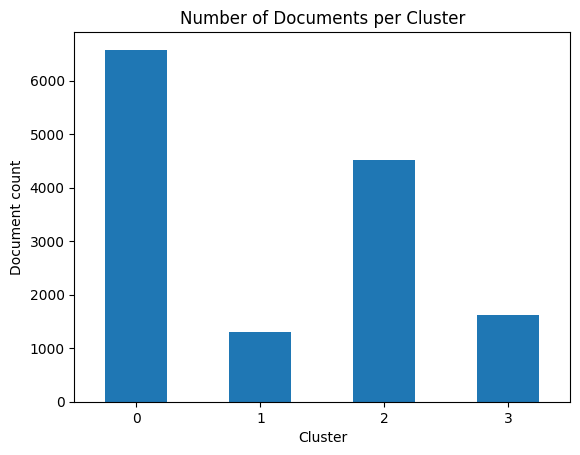

In [79]:
word_df.groupby('Cluster').count()[top_words[0]].\
    plot.bar(rot=0).\
    set(ylabel='Document count',
    title='Number of Documents per Cluster');

##Word Frequencies

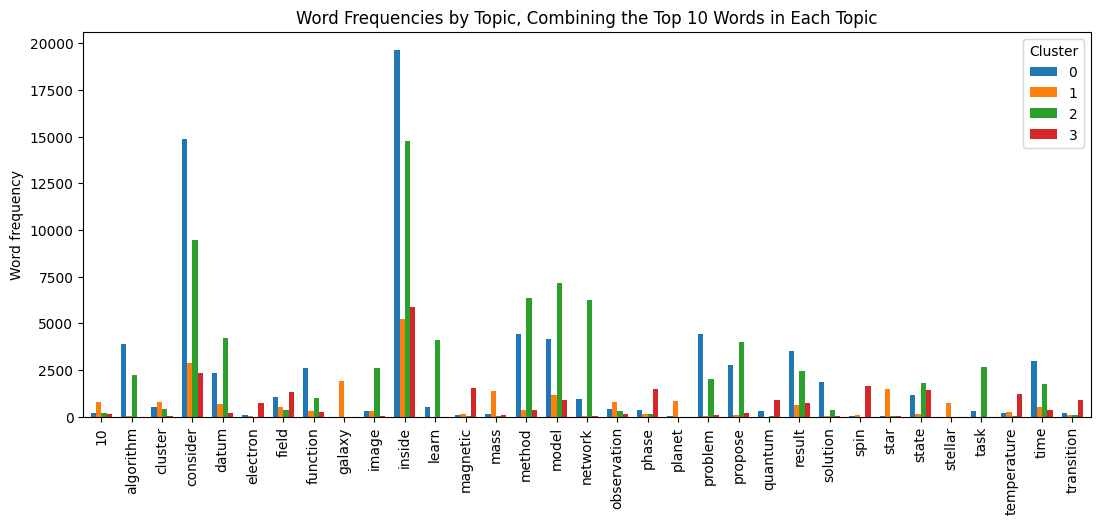

In [80]:
word_df.groupby('Cluster').sum().transpose().\
    plot.bar(figsize=(13,5), width=0.7).\
    set(ylabel='Word frequency',
    title=f'Word Frequencies by Topic, Combining the Top {number_of_top_words} Words in Each Topic');

## Word clouds

We can use a word cloud to show the relative frequency of these top words in each cluster.

In [81]:
word_totals = { i: word_df.groupby('Cluster').sum().loc[i].to_dict() for i in range(number_of_clusters) }

In [82]:
word_df

,10,algorithm,cluster,consider,datum,electron,field,function,galaxy,image,...,solution,spin,star,state,stellar,task,temperature,time,transition,Cluster
0,0,0,0,3,4,0,0,1,1,3,...,0,0,0,0,0,0,0,0,0,2
1,0,7,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,5,0,1,1,0,0,0,...,0,2,0,0,0,0,0,0,1,3
3,0,0,0,3,0,0,4,0,0,0,...,0,0,3,0,3,0,0,0,0,1
4,0,0,0,1,0,0,0,0,0,3,...,0,0,0,0,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13999,0,0,3,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14000,0,2,0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14001,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,3,3
14002,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


interactive(children=(IntSlider(value=0, description='Topic', max=3), Output()), _dom_classes=('widget-interac…

<function __main__.show_wordcloud(topic=0)>

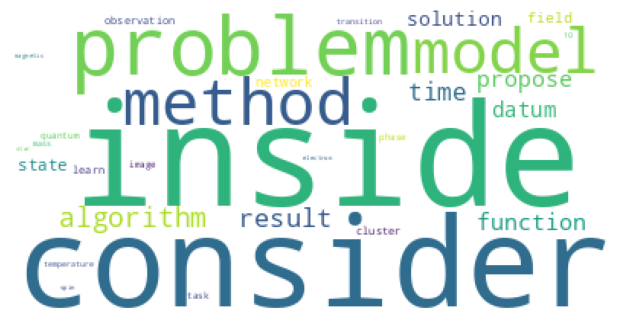

In [83]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from wordcloud import WordCloud

def show_wordcloud(topic=0):
    cloud = WordCloud(background_color='white', colormap='viridis')
    cloud.generate_from_frequencies(word_totals[topic])
    plt.gca().imshow(cloud)
    plt.axis('off')
    plt.tight_layout()

slider = IntSlider(min=0, max=number_of_clusters-1, step=1, value=0, description='Topic')
interact(show_wordcloud, topic=slider)

Words clouds directly from the **labels**

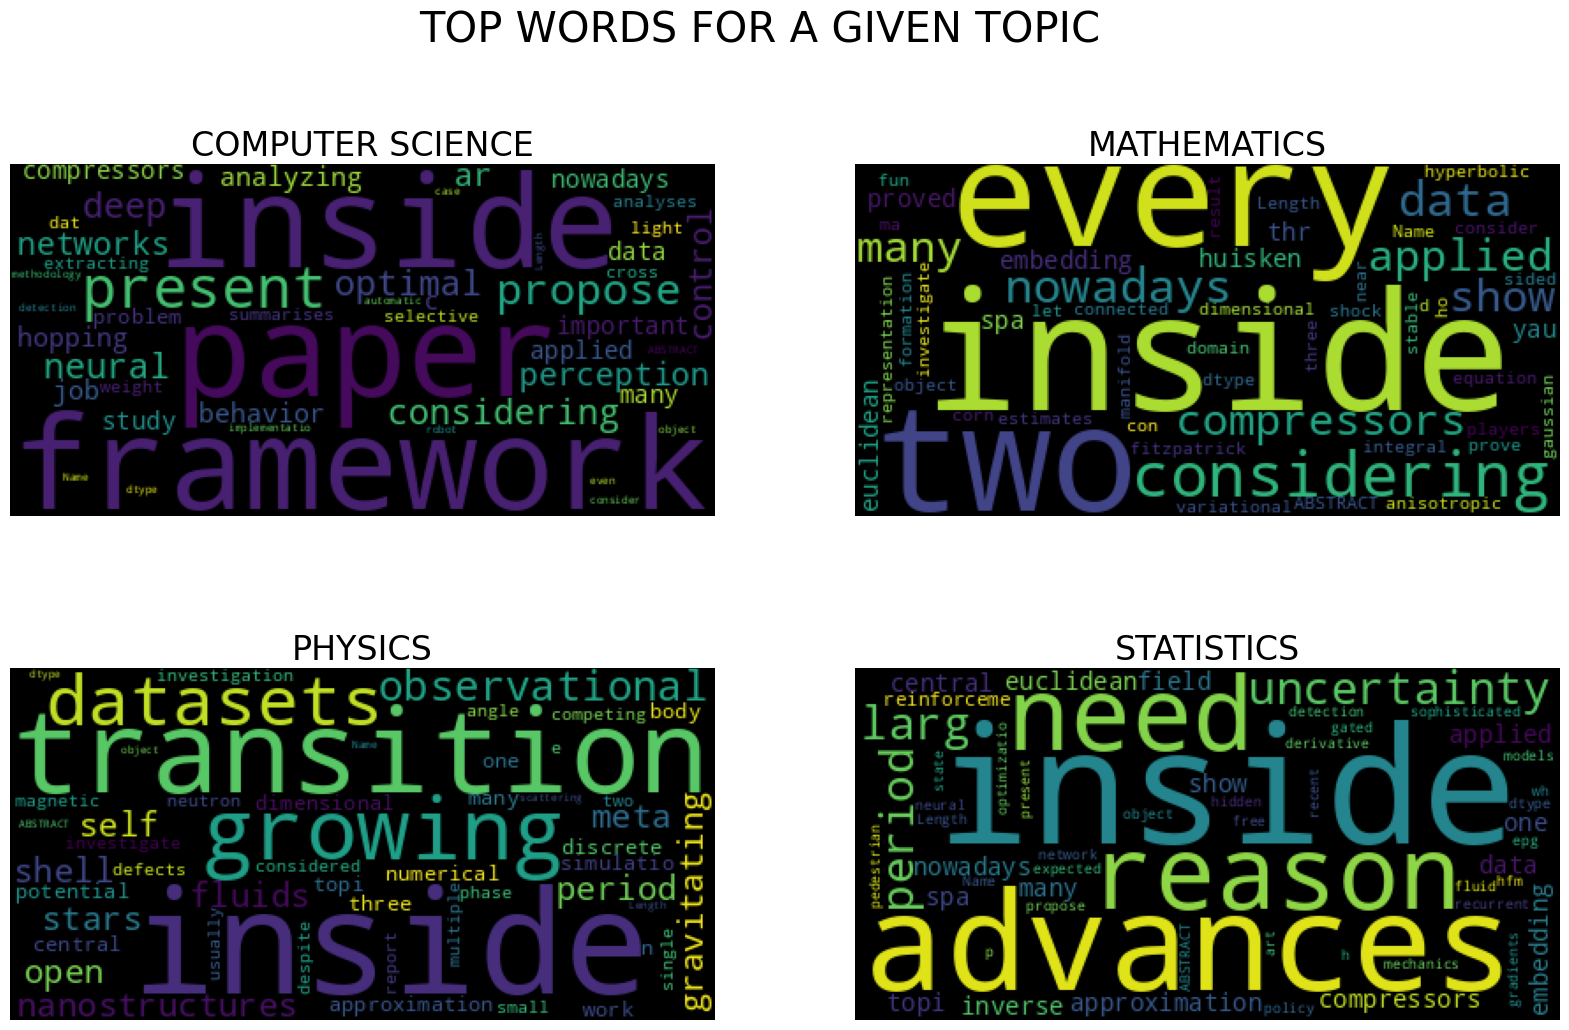

In [84]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wordcloud = WordCloud(stopwords=set(list(STOPWORDS)), random_state=42)
topics = ['Computer Science', 'Mathematics', 'Physics', 'Statistics']

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]

# Generate word clouds for each sub-topic
for i, topic in enumerate(topics):
    sub_topic_data = res_articles[res_articles[topic] == 1]
    wordcloud_image = wordcloud.generate(str(sub_topic_data['ABSTRACT']))
    # Display the word cloud on the current subplot
    axes[i].imshow(wordcloud_image)
    axes[i].set_title(topic.upper(), fontsize=24)
    axes[i].axis('off')

# Add a super title to the entire plot
plt.suptitle('TOP WORDS FOR A GIVEN TOPIC', fontsize=30)
plt.show()

##**PCA**
Visualization in a low-dimensional space

We can evaluate the degree of separation between clusters by employing principal component analysis (PCA) to project our data into a lower-dimensional space. However, it's important to note that the PCA method provided by scikit-learn doesn't work with sparse matrix representations. Given the size of our dataset, we can safely convert the feature matrix into a dense representation for this purpose.

In [85]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=117)
matrix_pca = pca.fit_transform(matrix.toarray())

matrix_pca.shape

(14004, 2)

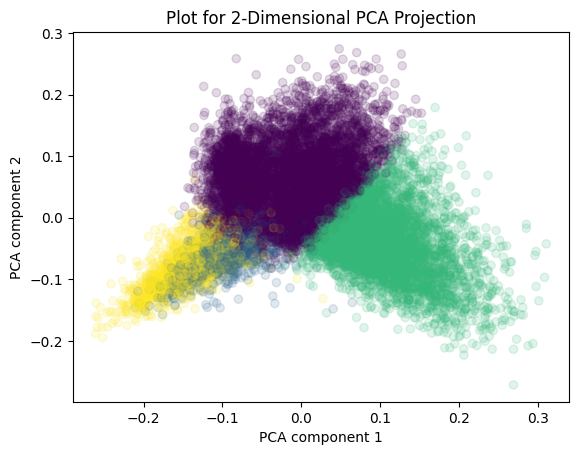

In [86]:
plt.scatter(matrix_pca[:,0], matrix_pca[:,1], c=word_df['Cluster'],
            cmap='viridis', alpha=0.15)
plt.gca().set(title='Plot for 2-Dimensional PCA Projection',
              xlabel='PCA component 1', ylabel='PCA component 2');

## Latent Dirichlet allocation (LDA)

**Clustering using TF-IDF (TfidfTransformer):**
When you perform clustering using values produced by the TF-IDF (Term Frequency-Inverse Document Frequency) transformer, you're essentially trying to group documents based on the similarity of the words they contain. TF-IDF assigns numerical values to words in documents, where words that appear frequently in one document but infrequently in others are considered important. Clustering using TF-IDF relies on the notion that documents with similar TF-IDF values are related to similar topics. However, it assumes that to be similar, documents must use exactly the same words when discussing a given topic. This approach creates clusters based on the closeness of these TF-IDF values in a high-dimensional space.

**Latent Dirichlet Allocation:**
LDA, on the other hand, takes a different approach. It aims to model the idealized concept that a "topic" is not a set of specific words but rather a mixture of words. Similarly, a "document" is not tied to a fixed set of topics but is a mixture of topics. In LDA, documents are thought of as being generated word by word. For each word, a topic is chosen based on a hidden probability distribution over the set of topics, and then a specific word is chosen based on another hidden probability distribution over the words associated with that topic. The training process in the LDA algorithm involves trying to construct these unknown probability distributions.

In essence, LDA doesn't focus on exact word matches like TF-IDF-based clustering. Instead, it assumes that documents can be a blend of multiple topics, and topics themselves are blends of words. This approach allows LDA to capture the underlying structure of topics and their relationships in a more flexible and probabilistic manner.

In [87]:
import gensim

Using Gensim for LDA:
While both scikit-learn and gensim provide tools for LDA, the explanation suggests using the gensim library and its LdaModel class. Gensim is favored because it offers better access to information about the generative model created by LDA. It allows you to extract more insights about the relationships between topics and words in your documents, making it a preferred choice when you want deeper insights into your data. Scikit-learn's LDA implementation is simpler but may not offer the same level of detail and flexibility.

In summary, LDA is a probabilistic model that views documents as mixtures of topics and topics as mixtures of words, allowing for a more nuanced understanding of the content in documents. Gensim is recommended for LDA because it provides better access to the underlying generative model for extracting insights.


In [88]:
abs_text_l = list(res_articles['ABSTRACT'])

In [89]:
abstract_text_list = res_articles['ABSTRACT'].values.tolist()

In [90]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS

def process_words(texts, stop_words=set()):
    result = []
    for t in texts:
        t = ' '.join(re.findall(r'\b\w[\w\']+\b', t))
        doc = nlp(t)
        result.append([token.lemma_.lower() for token in doc if token.lemma_ not in stop_words])
    return result

In [91]:
processed_text = process_words(abstract_text_list, stop_words=stopwords.union(['-PRON-']))

Compare the difference after preprocessing step

In [92]:
print(abstract_text_list[:1])

['a ever-growing datasets inside observational astronomy have challenged scientists inside many aspects, including an efficient and interactive data exploration and visualization. many tools have been developed to confront this challenge. however, they usually focus on displaying a actual images or focus on visualizing patterns within catalogs inside the predefined way. inside this paper we introduce vizic, the python visualization library that builds a connection between images and catalogs through an interactive map of a sky region. vizic visualizes catalog data over the custom background canvas with the help of a shape, size and orientation of each object inside a catalog. a displayed objects inside a map are highly interactive and customizable comparing to those inside a images. these objects should be filtered by or colored by their properties, such as redshift and magnitude. they also should be sub-selected with the help of the lasso-like tool considering further analysis with th

In [93]:
print(processed_text[:1])

[['grow', 'dataset', 'inside', 'observational', 'astronomy', 'challenge', 'scientist', 'inside', 'aspect', 'include', 'efficient', 'interactive', 'datum', 'exploration', 'visualization', 'tool', 'develop', 'confront', 'challenge', 'usually', 'focus', 'display', 'actual', 'image', 'focus', 'visualize', 'pattern', 'catalog', 'inside', 'predefine', 'way', 'inside', 'paper', 'introduce', 'vizic', 'python', 'visualization', 'library', 'build', 'connection', 'image', 'catalog', 'interactive', 'map', 'sky', 'region', 'vizic', 'visualize', 'catalog', 'datum', 'custom', 'background', 'canvas', 'help', 'shape', 'size', 'orientation', 'object', 'inside', 'catalog', 'display', 'object', 'inside', 'map', 'highly', 'interactive', 'customizable', 'compare', 'inside', 'image', 'object', 'filter', 'color', 'property', 'redshift', 'magnitude', 'sub', 'select', 'help', 'lasso', 'like', 'tool', 'consider', 'analysis', 'help', 'standard', 'python', 'function', 'jupyter', 'notebook', 'furthermore', 'vizic',

**Adding custom Stop words**

In [94]:
#abstract_text_list = res_articles['ABSTRACT'].values.tolist()
#stopwords = spacy.lang.en.stop_words.STOP_WORDS

custom_stopwords = {'inside', 'method', 'consider', 'every', 'two', 'advances', 'reason', 'use', 'help', 'model', 'base', 'datum'}  # The custom stop words were added here iteratively after studying word clouds.
stopwords_custom = stopwords.union(custom_stopwords) #previous plus the new ones

processed_text_new = process_words(abstract_text_list, stop_words=stopwords_custom)

In [95]:
print(processed_text_new[:1])

[['grow', 'dataset', 'observational', 'astronomy', 'challenge', 'scientist', 'aspect', 'include', 'efficient', 'interactive', 'exploration', 'visualization', 'tool', 'develop', 'confront', 'challenge', 'usually', 'focus', 'display', 'actual', 'image', 'focus', 'visualize', 'pattern', 'catalog', 'predefine', 'way', 'paper', 'introduce', 'vizic', 'python', 'visualization', 'library', 'build', 'connection', 'image', 'catalog', 'interactive', 'map', 'sky', 'region', 'vizic', 'visualize', 'catalog', 'custom', 'background', 'canvas', 'shape', 'size', 'orientation', 'object', 'catalog', 'display', 'object', 'map', 'highly', 'interactive', 'customizable', 'compare', 'image', 'object', 'filter', 'color', 'property', 'redshift', 'magnitude', 'sub', 'select', 'lasso', 'like', 'tool', 'analysis', 'standard', 'python', 'function', 'jupyter', 'notebook', 'furthermore', 'vizic', 'allow', 'custom', 'overlay', 'append', 'dynamically', 'sky', 'map', 'initially', 'implement', 'overlay', 'voronoi', 'delau

Let's replot the Word Cloud with new preprocessing (stop words and lemmatization)

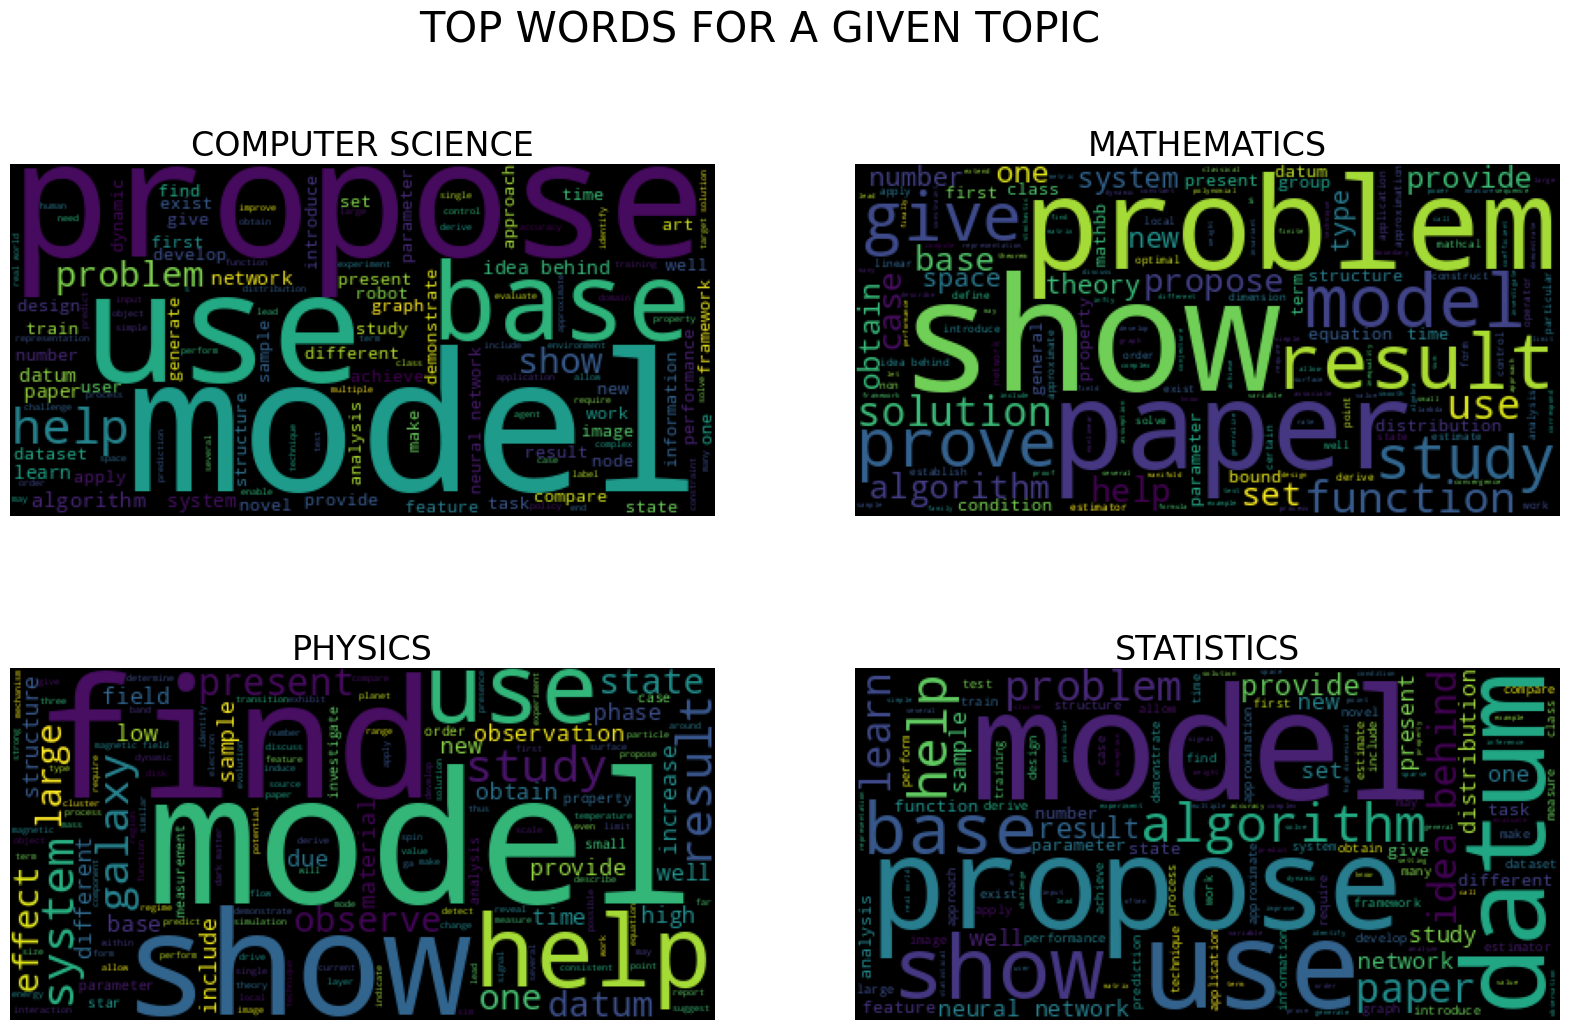

In [96]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re

# Define your lemmatization function
def my_lemmatizer(doc):
    doc_cleaned = ' '.join(re.findall(r'\b\w[\w\']+\b', doc))
    return ' '.join([w.lemma_.lower() for w in nlp(doc_cleaned) if w.lemma_ not in ['_', '.', '-PRON-']])

# Apply lemmatization to your text data
res_articles['ABSTRACT_lemmatized'] = res_articles['ABSTRACT'].apply(my_lemmatizer)

# Create a WordCloud object with custom stopwords
wordcloud = WordCloud(
    stopwords=set(list(STOPWORDS) + ['inside', 'method', 'consider', 'every', 'two', 'advances', 'reason']),
    random_state=42
)

topics = ['Computer Science', 'Mathematics', 'Physics', 'Statistics']

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]

# Generate word clouds for each sub-topic
for i, topic in enumerate(topics):
    sub_topic_data = res_articles[res_articles[topic] == 1]
    text_data = ' '.join(sub_topic_data['ABSTRACT_lemmatized'])  # Join the lemmatized text
    wordcloud_image = wordcloud.generate(text_data)
    # Display the word cloud on the current subplot
    axes[i].imshow(wordcloud_image)
    axes[i].set_title(topic.upper(), fontsize=24)
    axes[i].axis('off')

# Add a super title to the entire plot
plt.suptitle('TOP WORDS FOR A GIVEN TOPIC', fontsize=30)
plt.show()

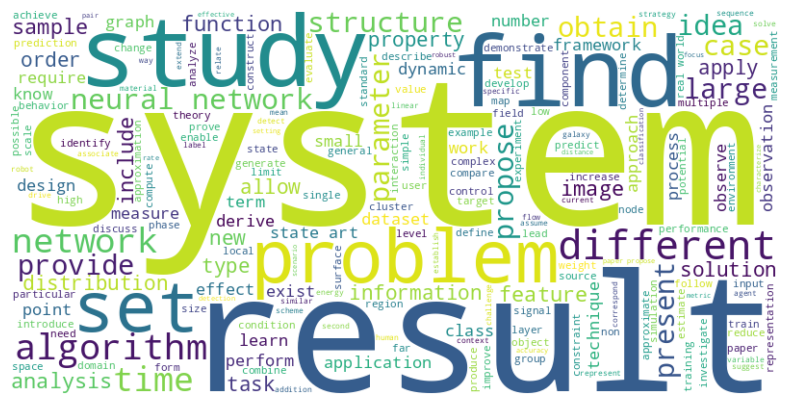

In [97]:
processed_text_new_as_text = [' '.join(tokens) for tokens in processed_text_new]
combined_text = ' '.join(processed_text_new_as_text)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Gensim's Vectorization Class:**

In Gensim, you typically use their Vectorization class to prepare text data for topic modeling, which includes creating a "bag of words" representation.
This class helps convert your text corpus into a format that's suitable for training an LDA model.

*Building the Vocabulary:*
First, you need to create a vocabulary or dictionary of words present in your corpus. You can do this using the gensim.corpora.Dictionary class. This dictionary maps words to unique integer IDs.

*Creating Word Count Vectors:*
Once you have your dictionary, you can create word count vectors for each document in your corpus. This is often referred to as "bag of words" representation.
You can use the doc2bow method of the dictionary to convert a document (a list of words) into a bag of words format.

In [98]:
dictionary = gensim.corpora.Dictionary(processed_text)
print(f'Number of unique tokens: {len(dictionary)}')

Number of unique tokens: 36358


In [99]:
corpus = [dictionary.doc2bow(t) for t in processed_text]

In [100]:
dictionary_new = gensim.corpora.Dictionary(processed_text_new)
print(f'Number of unique tokens: {len(dictionary_new)}')

Number of unique tokens: 36349


**Training the LDA Model:**

Now that you have your bag of words representation, you can train the LDA model using the *gensim.models.LdaModel* class. This class allows you to specify the number of topics and other parameters.

In [101]:
num_topics = 4

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=117, update_every=1,
                                            chunksize=1500,
                                            passes=5, iterations=10,
                                            alpha='asymmetric', eta=1/100,
                                            per_word_topics=True)

In [102]:
from pprint import pprint
pprint(lda_model.print_topics(num_words=10))

[(0,
  '0.036*"inside" + 0.033*"consider" + 0.013*"problem" + 0.011*"algorithm" + '
  '0.009*"method" + 0.009*"function" + 0.008*"result" + 0.007*"time" + '
  '0.006*"model" + 0.006*"paper"'),
 (1,
  '0.039*"inside" + 0.016*"_" + 0.016*"consider" + 0.010*"phase" + '
  '0.009*"spin" + 0.009*"state" + 0.009*"field" + 0.009*"magnetic" + '
  '0.007*"temperature" + 0.007*"energy"'),
 (2,
  '0.033*"inside" + 0.020*"consider" + 0.016*"model" + 0.014*"method" + '
  '0.014*"network" + 0.010*"datum" + 0.009*"propose" + 0.009*"learn" + '
  '0.008*"use" + 0.008*"base"'),
 (3,
  '0.031*"inside" + 0.017*"consider" + 0.009*"mass" + 0.009*"galaxy" + '
  '0.009*"star" + 0.007*"model" + 0.007*"find" + 0.006*"observation" + '
  '0.006*"10" + 0.006*"high"')]


In [103]:
corpus_new = [dictionary.doc2bow(t) for t in processed_text_new]

In [104]:
num_topics = 4

lda_model_new = gensim.models.ldamodel.LdaModel(corpus=corpus_new,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=117, update_every=1,
                                            chunksize=1500,
                                            passes=5, iterations=10,
                                            alpha='asymmetric', eta=1/100,
                                            per_word_topics=True)

In [105]:
from pprint import pprint
pprint(lda_model_new.print_topics(num_words=10))

[(0,
  '0.016*"problem" + 0.015*"algorithm" + 0.009*"propose" + 0.009*"time" + '
  '0.008*"function" + 0.008*"result" + 0.006*"paper" + 0.006*"distribution" + '
  '0.006*"approximation" + 0.006*"sample"'),
 (1,
  '0.014*"_" + 0.009*"field" + 0.009*"spin" + 0.009*"phase" + 0.009*"state" + '
  '0.008*"result" + 0.007*"order" + 0.007*"study" + 0.007*"magnetic" + '
  '0.007*"equation"'),
 (2,
  '0.018*"network" + 0.011*"learn" + 0.009*"propose" + 0.008*"task" + '
  '0.007*"image" + 0.007*"neural" + 0.007*"learning" + 0.006*"feature" + '
  '0.006*"deep" + 0.006*"system"'),
 (3,
  '0.008*"mass" + 0.008*"galaxy" + 0.007*"high" + 0.007*"star" + 0.007*"find" '
  '+ 0.006*"large" + 0.005*"observation" + 0.005*"10" + 0.005*"_" + '
  '0.005*"low"')]


Here it starts looking a little better, e.g. field, phase, spin, state are coming from Physics class

When you observe that certain words like "inside," "method," and "consider" appear as important words across all four main subjects in your dataset, it suggests that these words may be common stop words or generic terms that are not specific to any particular topic. This is a common occurrence in text data analysis and can be attributed to several factors.

To address this issue and identify more topic-specific words, you can consider the following steps:

Stopword Removal: Use a comprehensive stop word list to filter out common words from your text data. This can help reduce the influence of generic words on your topic modeling results.

TF-IDF Weights: Instead of simple word counts, you can use TF-IDF weights to represent the importance of words in each document. TF-IDF downweights common words and boosts the significance of less common words, potentially highlighting more topic-specific terms.

Topic Modeling Parameters: Adjust the parameters of your topic modeling algorithm, such as the number of topics and the model's sensitivity to words. Experimenting with different settings may help extract more topic-specific keywords.

Manual Inspection: After obtaining the top words for each topic, manually inspect the lists to identify and remove generic words that do not contribute to topic differentiation. This can be done during post-processing.

Domain-Specific Stop Words: Consider creating a custom stop word list specific to your domain or dataset. This can help filter out domain-irrelevant words more effectively.


**We have briefly solved this issue here by just adding the custom Stop words in processed_new**

##  More topic information


In [106]:
lda_model.get_document_topics(corpus[0])

[(0, 0.09080474), (2, 0.709436), (3, 0.19810684)]

In [107]:
def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []

    for wc in bow:
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(topic_list, name='Dominant_topic'),
                           pd.Series(percent_list, name='Percent'),
                           pd.Series(texts, name='Processed_text'),
                           pd.Series(keyword_list, name='Keywords')], axis=1)

    return result_df

In [108]:
main_topic_df = get_main_topic_df(lda_model, corpus, processed_text)

main_topic_df.head(10)

,Dominant_topic,Percent,Processed_text,Keywords
0,2,0.709,"[grow, dataset, inside, observational, astrono...",base consider datum inside learn method model ...
1,0,0.986,"[propose, framework, consider, optimal, matchi...",algorithm consider function inside method mode...
2,1,0.749,"[nanostructure, open, shell, transition, metal...",_ consider energy field inside magnetic phase ...
3,1,0.590,"[star, self, gravitating, fluid, inside, press...",_ consider energy field inside magnetic phase ...
4,2,0.967,"[deep, neural, perception, control, network, l...",base consider datum inside learn method model ...
5,2,0.682,"[analyze, job, hop, behavior, important, consi...",base consider datum inside learn method model ...
6,0,0.480,"[need, reason, uncertainty, inside, large, com...",algorithm consider function inside method mode...
7,0,0.421,"[period, approximation, central, topic, inside...",algorithm consider function inside method mode...
8,0,0.588,"[nowadays, datum, compressor, apply, problem, ...",algorithm consider function inside method mode...
9,1,0.578,"[inside, work, body, potential, nb, consider, ...",_ consider energy field inside magnetic phase ...


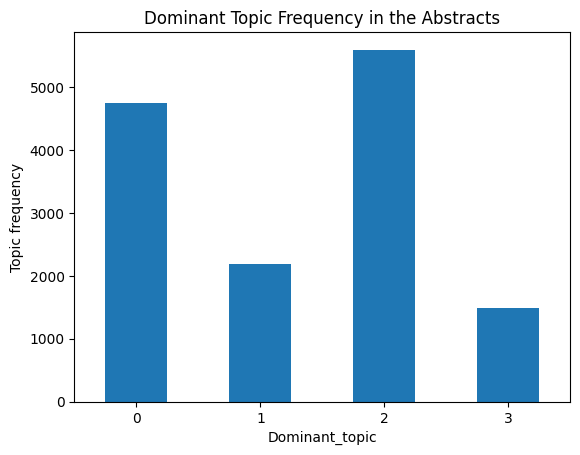

In [109]:
grouped_topics = main_topic_df.groupby('Dominant_topic')
grouped_topics.count()['Processed_text'].\
    plot.bar(rot=0).\
    set(title=f'Dominant Topic Frequency in the Abstracts',
        ylabel='Topic frequency');

In [110]:
main_topic_df_new = get_main_topic_df(lda_model_new, corpus_new, processed_text_new)
#main_topic_df.head(10)

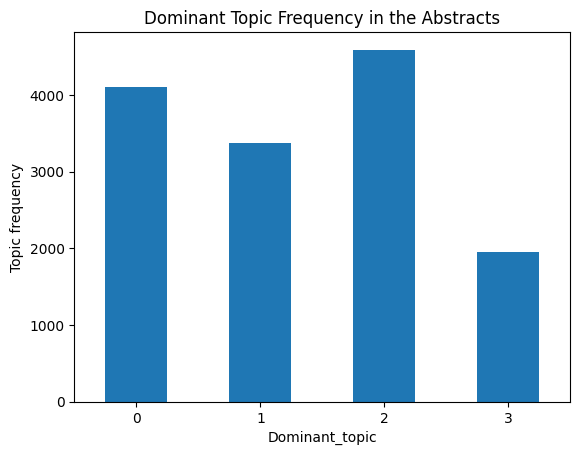

In [111]:
grouped_topics_new = main_topic_df_new.groupby('Dominant_topic')
grouped_topics_new.count()['Processed_text'].\
    plot.bar(rot=0).\
    set(title=f'Dominant Topic Frequency in the Abstracts',
        ylabel='Topic frequency');

## Representative data


In [112]:
representatives = pd.DataFrame()

for k in grouped_topics.groups.keys():
    representatives = pd.concat([representatives,
                                 grouped_topics.get_group(k).sort_values(['Percent'], ascending=False).head(1) ])

representatives

,Dominant_topic,Percent,Processed_text,Keywords
3063,0,0.996,"[inside, paper, consider, problem, testing, gr...",algorithm consider function inside method mode...
5529,1,0.995,"[nematic, fluctuation, occur, inside, wide, ra...",_ consider energy field inside magnetic phase ...
8414,2,0.994,"[monocular, 3d, facial, shape, reconstruction,...",base consider datum inside learn method model ...
8286,3,0.995,"[formation, dynamical, history, hot, jupiter, ...",10 consider find galaxy high inside mass model...


In [113]:
print(f'Document: {representatives.index[0]}  Dominant topic: {representatives.loc[representatives.index[0]]["Dominant_topic"]}\n')

print(abstract_text_list[representatives.index[0]])

Document: 3063  Dominant topic: 0

inside this paper we consider a problem of testing whether the graph has bounded arboricity. a family of graphs with bounded arboricity includes, among others, bounded-degree graphs, all minor-closed graph classes (e.g. planar graphs, graphs with bounded treewidth) and randomly generated preferential attachment graphs. graphs with bounded arboricity have been studied extensively inside a past, inside particular since considering many problems they allow considering much more efficient algorithms and/or better approximation ratios. we present the tolerant tester inside a sparse-graphs model. a sparse-graphs model allows access to degree queries and neighbor queries, and a distance was defined with respect to a actual number of edges. more specifically, our algorithm distinguishes between graphs that are $\epsilon$-close to having arboricity $\alpha$ and graphs that $c \cdot \epsilon$-far from having arboricity $3\alpha$, where $c$ was an absolute small

In [114]:
print(abstract_text_list[representatives.index[1]])

nematic fluctuations occur inside the wide range of disparate physical systems from liquid crystals to biological molecules to solids such as exotic magnets, cuprates and iron-based high-$t_{c}$ superconductors. spin-nematic fluctuations are thought to be closely linked to a formation of cooper-pairs inside iron-based superconductors. to date, it was unclear whether a anisotropy inherent inside this nematicity arises from electronic spin or orbital degrees of freedom. we have studied a iron-based mott insulators la$_{2}$o$_{2}$fe$_{2}$o{m}$_{2}$ m\,=\,(s, se) that are structurally similar to a iron pnictide superconductor. the spin nematic precursor phase is revealed by the critical slowing down of nematic fluctuations observed inside a spin-lattice relaxation rate ($1/t_1$) obtained by nuclear magnetic resonance. this was complemented by a observation of the change of electrical field gradient over the similar temperature range with the help of mössbauer spectroscopy. theoretical mode

In [115]:
representatives_new = pd.DataFrame()

for k in grouped_topics_new.groups.keys():
    representatives_new = pd.concat([ representatives_new,
                                 grouped_topics_new.get_group(k).sort_values(['Percent'], ascending=False).head(1) ])

representatives_new

,Dominant_topic,Percent,Processed_text,Keywords
8187,0,0.995,"[paper, study, remote, state, approximation, p...",algorithm approximation distribution function ...
13982,1,0.994,"[connect, manifold, corner, homology, theory, ...",_ equation field magnetic order phase result s...
7983,2,0.993,"[real, world, multimedia, compose, multiple, m...",deep feature image learn learning network neur...
5398,3,0.995,"[present, alma, detection, ci, co, co, emissio...",10 _ find galaxy high large low mass observati...


In [116]:
print(f'Document: {representatives_new.index[0]}  Dominant topic: {representatives_new.loc[representatives_new.index[0]]["Dominant_topic"]}\n')

print(abstract_text_list[representatives_new.index[0]])

print(abstract_text_list[representatives_new.index[1]])

Document: 8187  Dominant topic: 0

this paper studies remote state approximation inside a presence of an eavesdropper. the sensor transmits local state estimates over the packet dropping link to the remote estimator, while an eavesdropper should successfully overhear each sensor transmission with the certain probability. a objective was to determine when a sensor should transmit, inside order to minimize a approximation error covariance at a remote estimator, while trying to keep a eavesdropper error covariance above the certain level. this was done by solving an optimization problem that minimizes the linear combination of a expected approximation error covariance and a negative of a expected eavesdropper error covariance. structural results on a optimal transmission policy are derived, and shown to exhibit thresholding behaviour inside a approximation error covariances. inside a infinite horizon situation, it was shown that with unstable systems one should keep a expected approximati

The newly processed text produces a more relevant representative sentence